## Environment Setup

In [1]:
# To verify if the notebook is connected to gpu
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 12 08:46:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
!wget https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt

--2024-08-12 08:48:53--  https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/code_files/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     111  --.-KB/s    in 0s      

2024-08-12 08:48:53 (5.31 MB/s) - ‘requirements.txt’ saved [111/111]



In [11]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.6/990.6 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━

## Data Ingestion

In [12]:
import pandas as pd

class DataLoader:
    def __init__(self, url):
        self.url = url
        self.dataframe = None

    def load_data(self):
        """Load data from the URL into a Pandas DataFrame."""
        self.dataframe = pd.read_csv(self.url)
        return self.dataframe

In [28]:
dataset_url = 'https://raw.githubusercontent.com/21062872/fraud-detection-rag/main/data_files/dataset.csv'
data_loader = DataLoader(dataset_url)
df_raw = data_loader.load_data()

In [29]:
df_raw.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


## Data Pre-processing

In [15]:
import numpy as np
class DataPreprocessor:
    @staticmethod
    def preprocess(dataframe):
        """Preprocess the DataFrame by stripping single quotes from string values."""
        return dataframe.map(lambda x: x.strip("'") if isinstance(x, str) else x)

    @staticmethod
    def rename_columns(dataframe):
        """Rename columns of the DataFrame according to specified mappings."""
        renamed_columns = {
            'step': 'timeStep',
            'customer': 'customerId',
            'age': 'customerAge',
            'gender': 'customerGender',
            'zipcodeOri': 'originZipCode',
            'merchant': 'merchantName',
            'zipMerchant': 'merchantZipCode',
            'category': 'merchantCategory',
            'amount': 'amount',
            'fraud': 'isFraud'
        }
        return dataframe.rename(columns=renamed_columns)

    @staticmethod
    def preprocess_gender(dataframe):
        """
        Preprocess the 'customerGender' column by standardizing values and handling unknowns.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the preprocessed 'customerGender' column.
        """
        dataframe['customerGender'] = dataframe['customerGender'].replace({'E': np.nan, 'U': np.nan})
        return dataframe

    @staticmethod
    def encode_gender(dataframe):
        """
        Encode the 'customerGender' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'customerGender' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'customerGender' column.
        """
        return pd.get_dummies(dataframe, columns=['customerGender'], prefix='Gender', dummy_na=True)

    @staticmethod
    def encode_merchant_category(dataframe):
        """
        Encode the 'merchantCategory' column using one-hot encoding.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame with the 'merchantCategory' column.

        Returns:
        pd.DataFrame: The DataFrame with the one-hot encoded 'merchantCategory' column.
        """
        return pd.get_dummies(dataframe, columns=['merchantCategory'], prefix='Category')

    @staticmethod
    def convert_to_category_codes(df, column_name):
        """
        Convert a categorical column in the DataFrame to category codes.

        Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to convert.

        Returns:
        pd.DataFrame: The DataFrame with the categorical column converted to category codes.
        """
        df[column_name] = df[column_name].astype('category').cat.codes
        return df

    @staticmethod
    def filter_records_with_unidentified_data(df, column_name):
        """
        Filters out rows where 'customerAge' is 'U'.

        Parameters:
        df (pd.DataFrame): The DataFrame to be filtered.

        Returns:
        pd.DataFrame: A DataFrame with rows where 'customerAge' is not 'U'.
        """
        filtered_df = df[df[column_name] != 'U']

        return filtered_df



In [30]:
data_preprocessor = DataPreprocessor()
df_processed = data_preprocessor.preprocess(df_raw)
df_processed = data_preprocessor.rename_columns(df_processed)
df_processed = data_preprocessor.preprocess_gender(df_processed)
df_processed = data_preprocessor.filter_records_with_unidentified_data(df_processed, 'customerAge')
#Encoded dataset
df_encoded = data_preprocessor.encode_gender(df_processed)
df_encoded = data_preprocessor.encode_merchant_category(df_processed)

In [31]:
df_processed.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0


In [ ]:
df_encoded.head(5)

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,amount,isFraud,Category_es_barsandrestaurants,...,Category_es_home,Category_es_hotelservices,Category_es_hyper,Category_es_leisure,Category_es_otherservices,Category_es_sportsandtoys,Category_es_tech,Category_es_transportation,Category_es_travel,Category_es_wellnessandbeauty
0,0,C1093826151,4,M,28007,M348934600,28007,4.55,0,False,...,False,False,False,False,False,False,False,True,False,False
1,0,C352968107,2,M,28007,M348934600,28007,39.68,0,False,...,False,False,False,False,False,False,False,True,False,False
2,0,C2054744914,4,F,28007,M1823072687,28007,26.89,0,False,...,False,False,False,False,False,False,False,True,False,False
3,0,C1760612790,3,M,28007,M348934600,28007,17.25,0,False,...,False,False,False,False,False,False,False,True,False,False
4,0,C757503768,5,M,28007,M348934600,28007,35.72,0,False,...,False,False,False,False,False,False,False,True,False,False


### Exploratory Data Analysis (EDA)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import missingno as msno

class EDA:
    def __init__(self, df):
        self.df = df

    def plot_imbalance(self, target_variable):
        """Plot the class imbalance for fraud variable."""
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        counts = self.df[target_variable].value_counts()

        plt.figure(figsize=(6, 4))
        counts.plot(kind='bar', color=['blue', 'red'])
        plt.title(f'Imbalance of {target_variable}')
        plt.xlabel(f'{target_variable} (1) vs Not {target_variable} (0)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.show()

    def plot_categorical_distribution(self, df, column):
        """
        Plot categorical distribution for a given column.

        Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        column (str): The column name to plot.
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=df)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.show()

    def plot_missing_values_bar(self, dataframe):
        """
        Plot missing values in the given DataFrame using a bar chart.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame to visualize for missing values.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        msno.bar(dataframe)
        plt.title('Non-Missing Values Bar Chart')
        plt.xlabel('Columns')
        plt.ylabel('Count of Non-Missing Values')
        plt.show()

    def plot_customer_age_and_gender_distribution(self, dataframe, column):
        """
        Plot the distribution of customer age and gender using a histogram with KDE.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the customer age data.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(8, 4))
        sns.histplot(dataframe[column], bins=10, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(f'{column}')
        plt.ylabel('Frequency')
        plt.show()

    def plot_amount_distribution(sef, dataframe):
        """
        Plot a scatter plot to see the distribution of the 'amount' column,
        marking fraud transactions in red (isFraud = 1).

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))

        # Scatter plot for non-fraudulent transactions (isFraud = 0)
        plt.scatter(dataframe[dataframe['isFraud'] == 0]['timeStep'],
                    dataframe[dataframe['isFraud'] == 0]['amount'],
                    alpha=0.5, c='blue', label='Non-Fraudulent')

        # Scatter plot for fraudulent transactions (isFraud = 1)
        plt.scatter(dataframe[dataframe['isFraud'] == 1]['timeStep'],
                    dataframe[dataframe['isFraud'] == 1]['amount'],
                    alpha=0.5, c='red', label='Fraudulent')

        # Plot styling
        plt.title('Distribution of Transaction Amounts Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Transaction Amount')
        plt.legend()

        plt.show()

    def plot_amount_boxplot(self,dataframe):
        """
        Plot a detailed and customized box plot to see the distribution of the 'amount' column.

        Parameters:
        dataframe (pd.DataFrame): The DataFrame containing the data to plot.

        Returns:
        None
        """
        # Setting the aesthetic style of the plots
        sns.set_style("whitegrid")

        # Creating the box plot
        plt.figure(figsize=(12, 8))
        box_plot = sns.boxplot(
            y=dataframe['amount'],
            color='skyblue',
            flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red'}
        )

        # Customizing the plot
        plt.title('Box Plot of Transaction Amounts', fontsize=16)
        plt.ylabel('Transaction Amount', fontsize=14)
        plt.xlabel('Transactions', fontsize=14)

        # Adding grid lines for better readability
        plt.grid(True, linestyle='--', linewidth=0.5)

        # Annotating the plot with more details
        plt.annotate(
            'Outliers',
            xy=(0, dataframe['amount'].max()),
            xytext=(0, dataframe['amount'].max() + 10),
            arrowprops=dict(facecolor='black', arrowstyle='->'),
            fontsize=12
        )

        # Adding mean and median lines
        mean_value = dataframe['amount'].mean()
        median_value = dataframe['amount'].median()

        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        plt.axhline(median_value, color='blue', linestyle='-', linewidth=1.5, label=f'Median: {median_value:.2f}')

        plt.legend()

        # Showing the plot
        plt.show()

    def plot_fraud_percentage_by_age(self, df, age_column='customerAge'):
        """
        Creates a stacked bar plot to show the percentage of fraud and non-fraud transactions by customer age.

        Parameters:
        df (pd.DataFrame): DataFrame containing the transaction data.
        age_column (str): Column name representing customer age. Default is 'customerAge'.
        """

        # Calculate the percentage of fraud and not fraud transactions by the specified age column
        age_fraud_summary = df.groupby([age_column, 'isFraud']).size().unstack(fill_value=0)
        age_fraud_summary_percentage = age_fraud_summary.div(age_fraud_summary.sum(axis=1), axis=0) * 100

        # Create the stacked bar plot
        fig, ax = plt.subplots(figsize=(12, 8))
        age_fraud_summary_percentage.plot(kind='bar', stacked=True, ax=ax, color=['blue', 'red'])

        # Set labels and title
        ax.set_xlabel('Customer Age')
        ax.set_ylabel('Percentage of Transactions')
        ax.set_title('Percentage of Fraud and Not Fraud Transactions by Customer Age')
        ax.legend(title='Transaction Type', labels=['Not Fraud', 'Fraud'])

        # Show the plot
        plt.show()


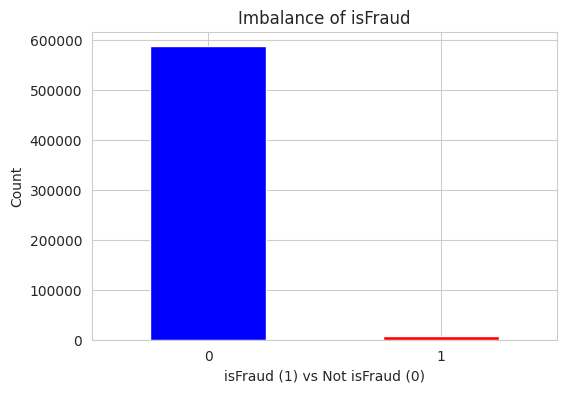

In [ ]:
# plot imabalnce of target variable
eda = EDA(df_processed)
eda.plot_imbalance('isFraud')

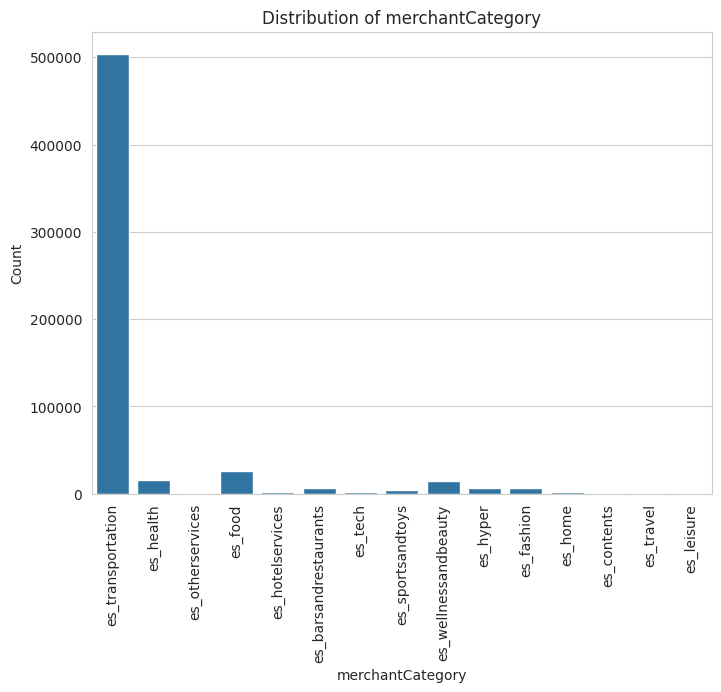

In [ ]:
#Plot categorical distribution for merchantCategory column
eda.plot_categorical_distribution(df_processed, 'merchantCategory')

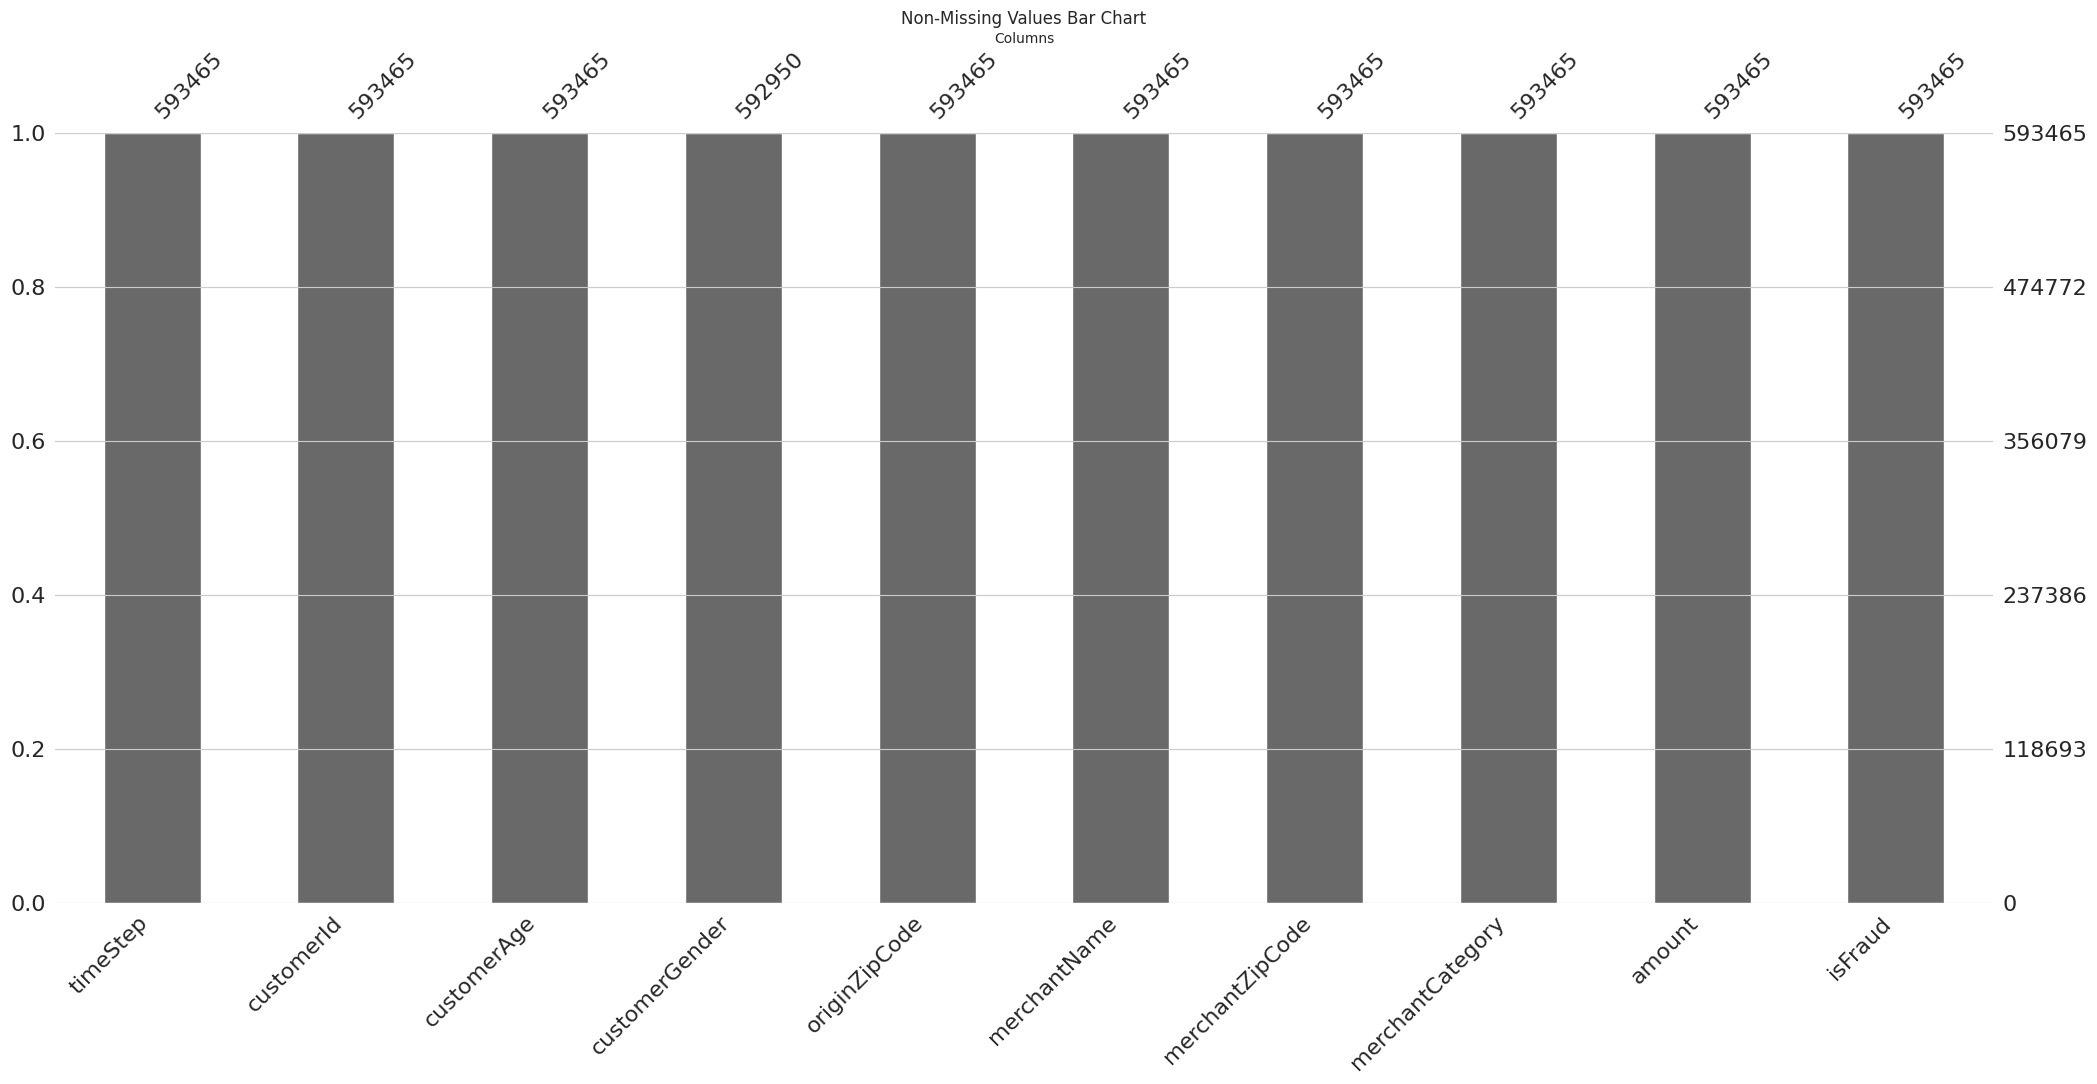

In [ ]:
# Plot non-missing values in the given DataFrame using a bar chart
eda.plot_missing_values_bar(df_processed)

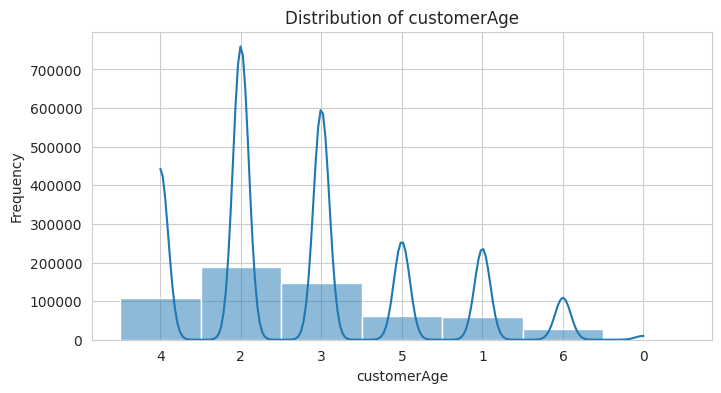

In [ ]:
#Plot the distribution of customer age
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerAge')

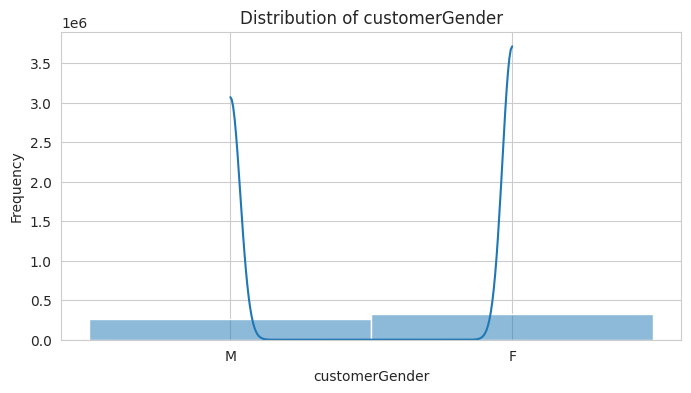

In [ ]:
#Plot the distribution of customer gender
eda.plot_customer_age_and_gender_distribution(df_processed, 'customerGender')

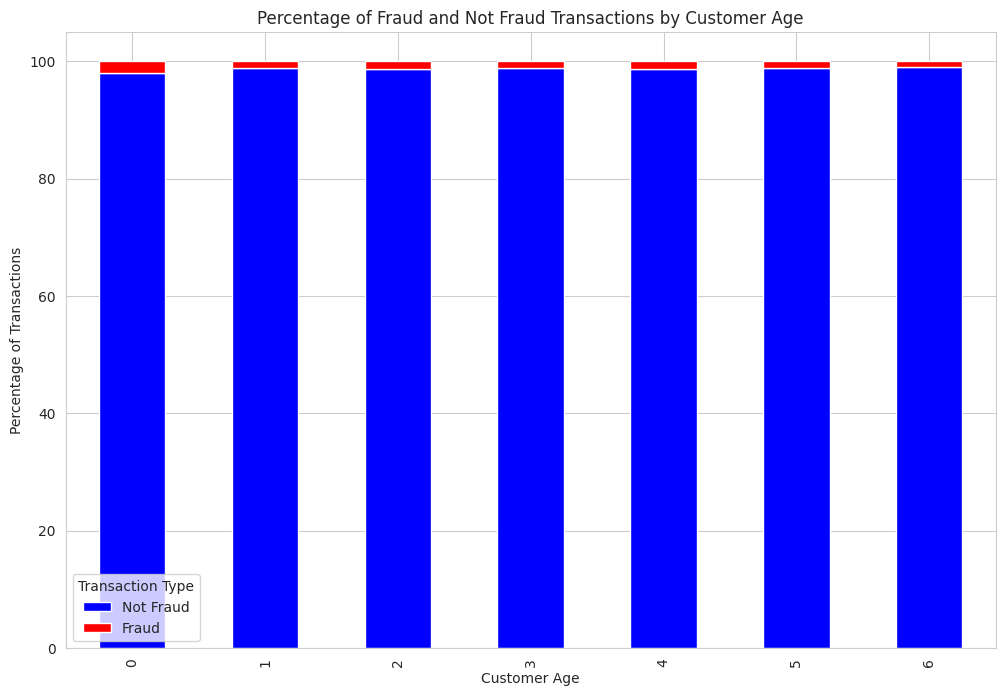

In [ ]:
eda.plot_fraud_percentage_by_age(df_processed, age_column='customerAge')

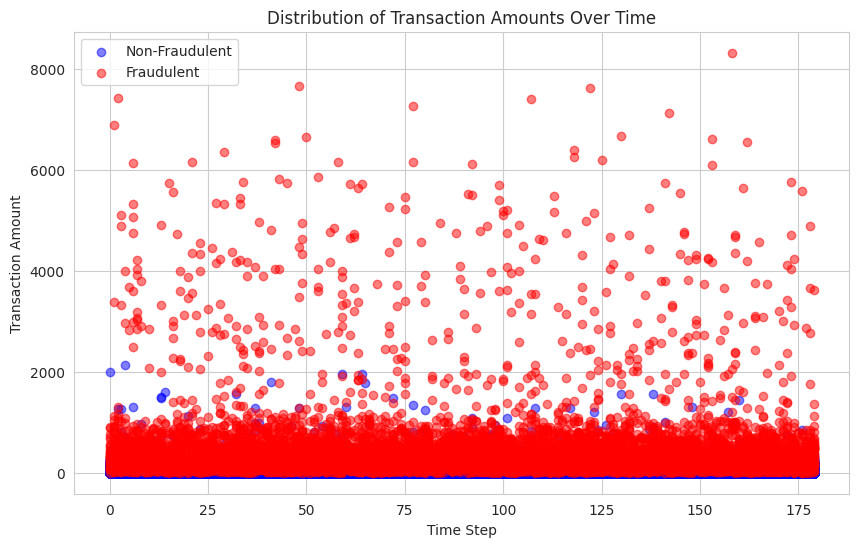

In [ ]:
eda.plot_amount_distribution(df_processed)

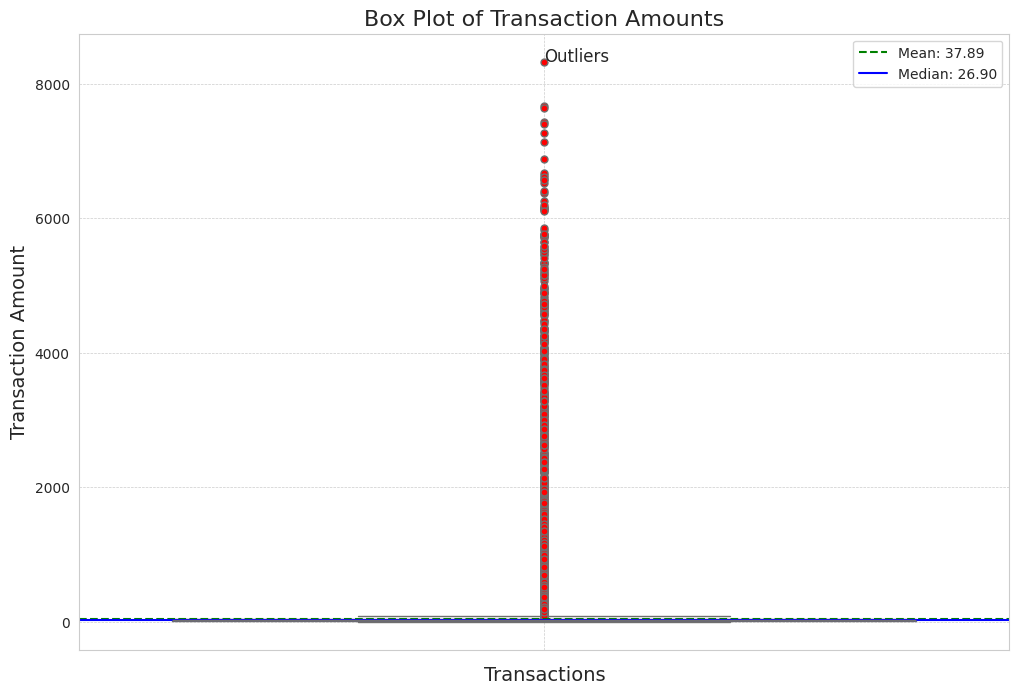

In [ ]:
eda.plot_amount_boxplot(df_processed)

EDA for fraudlent transactions

In [ ]:
df_fraud_trx = df_processed[df_processed['isFraud'] == 1]

In [ ]:
edaFraud = EDA(df_fraud_trx)

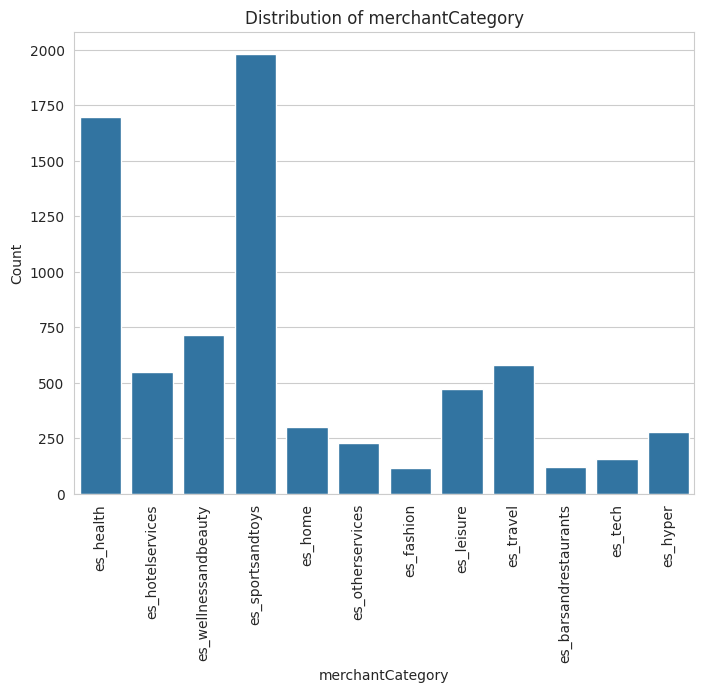

In [ ]:
#Plot categorical distribution for merchantCategory column
edaFraud.plot_categorical_distribution(df_fraud_trx, 'merchantCategory')

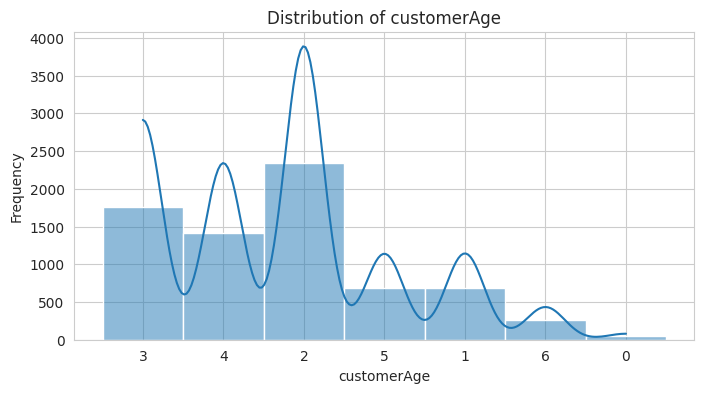

In [ ]:
#Plot the distribution of customer age
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerAge')

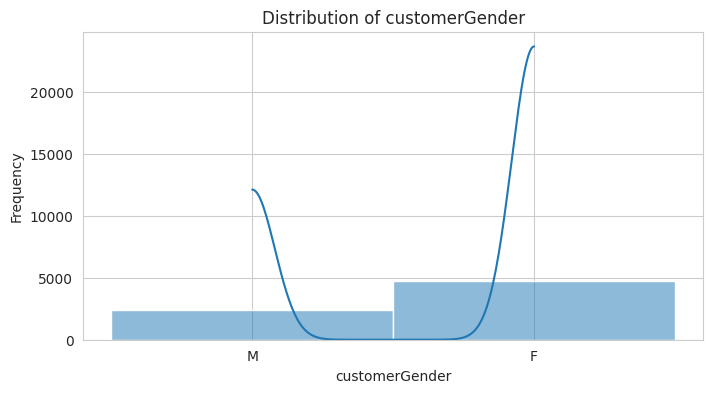

In [ ]:
#Plot the distribution of customer gender
edaFraud.plot_customer_age_and_gender_distribution(df_fraud_trx, 'customerGender')

### More pre-processing to handle categorical values

In [32]:
df_processed_rag = df_processed.copy()

In [33]:
# Convert categorical column to category codes
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'merchantCategory')
df_processed = data_preprocessor.convert_to_category_codes(df_processed, 'customerGender')

In [34]:
df_processed

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0
...,...,...,...,...,...,...,...,...,...,...
594638,179,C1753498738,3,0,28007,M1823072687,28007,12,20.53,0
594639,179,C650108285,4,0,28007,M1823072687,28007,12,50.73,0
594640,179,C123623130,2,0,28007,M349281107,28007,2,22.44,0
594641,179,C1499363341,5,1,28007,M1823072687,28007,12,14.46,0


## Feature Engineering

In [35]:
def process_transactions(df):
    """
    Adds 'IslargeTransaction' and 'countForCustomerSameTime' columns to the DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing the transaction data with 'amount', 'timeStep', and 'customerId' columns.

    Returns:
    pd.DataFrame: DataFrame with the new columns added.
    """
    # Add 'IslargeTransaction' column based on the condition
    df['IslargeTransaction'] = df['amount'].apply(lambda x: 1 if x >= 5000 else 0)

    # Calculate the count of transactions for each customer at each time step
    df['countForCustomerSameTime'] = df.groupby(['timeStep', 'customerId'])['customerId'].transform('count')

    return df

def add_avg_transaction_amount(df, customer_id_col='customerId', amount_col='amount'):
    """
    Adds a new column to the DataFrame that contains the average transaction amount
    for each customerId.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the transaction data.
    customer_id_col (str): The column name representing customer IDs. Default is 'customerId'.
    amount_col (str): The column name representing transaction amounts. Default is 'amount'.

    Returns:
    pd.DataFrame: The DataFrame with an added column 'avgTransactionAmount'.
    """
    # Calculate the average transaction amount for each customerId
    avg_transaction_amount = df.groupby(customer_id_col)[amount_col].mean()

    # Map the average transaction amount back to the original DataFrame
    df['avgTransactionAmount'] = df[customer_id_col].map(avg_transaction_amount)

    return df

In [36]:
# Apply the function to process the DataFrame
df_processed = process_transactions(df_processed)
df_processed_rag = process_transactions(df_processed_rag)

In [37]:
df_processed = add_avg_transaction_amount(df_processed)
df_processed_rag = add_avg_transaction_amount(df_processed_rag)


In [38]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0,0,1,28.240719
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0,0,1,32.661361
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0,0,1,41.443692
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0,0,1,30.338772
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0,0,1,31.696759


In [39]:
df_processed_rag.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,C1093826151,4,M,28007,M348934600,28007,es_transportation,4.55,0,0,1,28.240719
1,0,C352968107,2,M,28007,M348934600,28007,es_transportation,39.68,0,0,1,32.661361
2,0,C2054744914,4,F,28007,M1823072687,28007,es_transportation,26.89,0,0,1,41.443692
3,0,C1760612790,3,M,28007,M348934600,28007,es_transportation,17.25,0,0,1,30.338772
4,0,C757503768,5,M,28007,M348934600,28007,es_transportation,35.72,0,0,1,31.696759


# Baseline models for Fraud Detection

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

def train_random_forest(df, categorical_columns, target_column='isFraud', test_size=0.25, n_estimators=10, random_state=42):
    """
    Trains a Random Forest classifier and evaluates its performance.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features and target variable.
    categorical_columns (list): List of column names that need to be encoded.
    target_column (str): The name of the target column in the DataFrame. Default is 'isFraud'.
    test_size (float): Proportion of the data to include in the test split. Default is 0.25.
    random_state (int): Seed for the random number generator. Default is 42.

    Returns:
    None
    """
    # Encode categorical features using LabelEncoder
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Initialize the Random Forest Classifier
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    rf_clf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_clf.predict(X_test)

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))


**Experiment 1: RandomForest without oversampling**

In [ ]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed, categorical_columns)

Accuracy: 0.9964682173259553
Confusion Matrix:
 [[146490    162]
 [   362   1353]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    146652
           1       0.89      0.79      0.84      1715

    accuracy                           1.00    148367
   macro avg       0.95      0.89      0.92    148367
weighted avg       1.00      1.00      1.00    148367



### Addressing Dataset Imbalance

### SMOTE - (Synthetic Minority Over-sampling Technique)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

class SmoteOverSampling:
    def __init__(self, dataframe, target_column, test_size=0.2, random_state=42):
        """
        Initialize the SmoteOverSampling with the given parameters.

        :param dataframe: DataFrame containing the dataset
        :param target_column: Column name of the target variable
        :param test_size: Proportion of the dataset to include in the test split
        :param random_state: Random state for reproducibility
        """
        self.dataframe = dataframe
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state

    def encode_categorical(self):
        """
        Encode categorical features using integer encoding.

        This method converts categorical features into integer labels
        that can be provided to machine learning algorithms.
        """
        label_encoders = {}
        for column in self.dataframe.select_dtypes(include=['object']).columns:
            label_encoders[column] = LabelEncoder()
            self.dataframe[column] = label_encoders[column].fit_transform(self.dataframe[column])
        self.label_encoders = label_encoders

    def apply_smote(self):
        """
        Apply SMOTE to balance the dataset.

        This method separates the features and the target variable,
        applies SMOTE to generate synthetic samples for the minority class,
        and stores the resampled features and target in instance variables.
        """
        X = self.dataframe.drop(self.target_column, axis=1)
        y = self.dataframe[self.target_column]

        smote = SMOTE(random_state=self.random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        self.X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
        self.y_resampled = pd.Series(y_resampled, name=self.target_column)

        # Create DataFrame for the original and synthetic samples
        self.df_processed_os = self.X_resampled.copy()
        self.df_processed_os[self.target_column] = self.y_resampled

    def scale_features(self):
        """
        Scale the features using StandardScaler.

        This method standardizes the features by removing the mean and
        scaling to unit variance, and stores the scaled features.
        """
        scaler = StandardScaler()
        self.X_resampled_scaled = scaler.fit_transform(self.X_resampled)

    def split_data(self):
        """
        Split the data into training and testing sets.

        This method splits the resampled and scaled data into training
        and testing sets and returns them.

        :return: X_train, X_test, y_train, y_test
        """
        X_train, X_test, y_train, y_test = train_test_split(
            self.X_resampled_scaled, self.y_resampled,
            test_size=self.test_size, random_state=self.random_state
        )
        return X_train, X_test, y_train, y_test

In [ ]:
# Initialize the preprocessor
preprocessor = SmoteOverSampling(df_processed, target_column='isFraud')

# Encode categorical features
preprocessor.encode_categorical()

# Apply SMOTE to balance the dataset
preprocessor.apply_smote()

# The new DataFrame with original and synthetic samples
df_processed_os = preprocessor.df_processed_os

# Optionally, you can now scale features and split the data if needed
preprocessor.scale_features()
X_train, X_test, y_train, y_test = preprocessor.split_data()

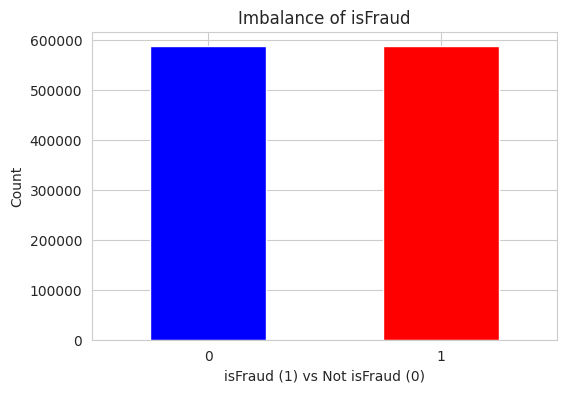

In [ ]:
# plot imabalnce of target variable after SMOTE
eda = EDA(df_processed_os)
eda.plot_imbalance('isFraud')

**Experiment 2: RandomForest with oversampled data (SMOTE)**

In [ ]:
# Columns to encode
categorical_columns = ['customerId', 'merchantName', 'customerAge']

# Call the function to train the Random Forest classifier
train_random_forest(df_processed_os, categorical_columns)

Accuracy: 0.9962304186452705
Confusion Matrix:
 [[145625    883]
 [   222 146406]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    146508
           1       0.99      1.00      1.00    146628

    accuracy                           1.00    293136
   macro avg       1.00      1.00      1.00    293136
weighted avg       1.00      1.00      1.00    293136



# Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

def create_nn_model(input_dim):
    """
    Creates a neural network model.

    Parameters:
    input_dim (int): Number of features in the input data.

    Returns:
    model (Sequential): Compiled neural network model.
    """
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

def train_and_evaluate_nn(df, categorical_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Trains a neural network on the data and evaluates its performance.

    Parameters:
    df (pd.DataFrame): DataFrame containing the features and target variable.
    categorical_columns (list): List of column names that need to be encoded.
    target_column (str): The name of the target column in the DataFrame.
    test_size (float): Proportion of the data to include in the test split.
    random_state (int): Seed for the random number generator.

    Returns:
    None
    """
    # Define features and target variable
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the neural network model
    model = create_nn_model(input_dim=X_train.shape[1])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    # Evaluate the model
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

**Experiment 3: Neural Network without oversampling**

In [ ]:
# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed, categorical_columns)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9838 - loss: 0.6973 - val_accuracy: 0.9921 - val_loss: 0.1289
Epoch 2/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9917 - loss: 0.0415 - val_accuracy: 0.9932 - val_loss: 0.0241
Epoch 3/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9938 - loss: 0.0245 - val_accuracy: 0.9942 - val_loss: 0.0204
Epoch 4/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9937 - loss: 0.0240 - val_accuracy: 0.9943 - val_loss: 0.0205
Epoch 5/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - accuracy: 0.9940 - loss: 0.0220 - val_accuracy: 0.9941 - val_loss: 0.0197
Epoch 6/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9940 - loss: 0.0223 - val_accuracy: 0.9945 - val_loss: 0.0194
Epoch 7/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9943 - loss: 0.0215 - val_accuracy: 0.9945 - val_loss: 0.0195
Epoch 8/10
11128/11128 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step - accuracy: 

**Experiment 4: Neural Network with Oversampling (SMOTE)**

In [ ]:
# Call the function to train and evaluate the neural network
train_and_evaluate_nn(df_processed_os, categorical_columns)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step - accuracy: 0.8927 - loss: 0.9870 - val_accuracy: 0.9299 - val_loss: 0.1793
Epoch 2/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step - accuracy: 0.9405 - loss: 0.1543 - val_accuracy: 0.9583 - val_loss: 0.1183
Epoch 3/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - accuracy: 0.9577 - loss: 0.1199 - val_accuracy: 0.9645 - val_loss: 0.1034
Epoch 4/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9610 - loss: 0.1108 - val_accuracy: 0.9603 - val_loss: 0.1103
Epoch 5/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step - accuracy: 0.9623 - loss: 0.1059 - val_accuracy: 0.9658 - val_loss: 0.1062
Epoch 6/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - accuracy: 0.9640 - loss: 0.1025 - val_accuracy: 0.9627 - val_loss: 0.1125
Epoch 7/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 78s 2ms/step - accuracy: 0.9646 - loss: 0.1003 - val_accuracy: 0.9677 - val_loss: 0.0928
Epoch 8/10
22030/22030 ━━━━━━━━━━━━━━━━━━━━ 84s 3ms/step - accuracy: 

# XGBOOST

In [ ]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,210,4,1,0,30,0,12,4.55,0,0,1,28.240719
1,0,2746,2,1,0,30,0,12,39.68,0,0,1,32.661361
2,0,2280,4,0,0,18,0,12,26.89,0,0,1,41.443692
3,0,1646,3,1,0,30,0,12,17.25,0,0,1,30.338772
4,0,3578,5,1,0,30,0,12,35.72,0,0,1,31.696759


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb


def preprocess_data(df):
    """
    Preprocess the data by splitting into features and target, and performing train-test split.
    :param df: DataFrame
    :return: X_train, X_test, y_train, y_test
    """
    X = df.drop(columns=['isFraud'])
    y = df['isFraud']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test


def build_pipeline():
    """
    Build and return a machine learning pipeline with preprocessing and XGBoost classifier.
    :return: Pipeline
    """
    numeric_features = ['amount', 'customerAge', 'countForCustomerSameTime', 'timeStep', 'avgTransactionAmount']
    categorical_features = ['customerGender', 'merchantName', 'merchantCategory']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', xgb_model)
    ])

    return pipeline


def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    """
    Train and evaluate the model.
    :param pipeline: Pipeline
    :param X_train: Training features
    :param X_test: Testing features
    :param y_train: Training target
    :param y_test: Testing target
    """
    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)

    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print("Classification Report:")
    print(classification_report(y_test, y_pred_test))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_test))


def main():
    """
    Main function to run the data processing, model training, and evaluation.
    :param file_path: str, path to the CSV file
    """
    X_train, X_test, y_train, y_test = preprocess_data(df_processed)
    pipeline = build_pipeline()
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)

**Experiment 5: XGBoost (Extreme Gradient Boosting)**

In [ ]:
if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:06:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Accuracy: 0.9975
Test Accuracy: 0.9967
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175882
           1       0.90      0.82      0.86      2158

    accuracy                           1.00    178040
   macro avg       0.95      0.91      0.93    178040
weighted avg       1.00      1.00      1.00    178040

Confusion Matrix:
[[175690    192]
 [   397   1761]]


# FAISS (Facebook AI for Similarity Search)

In [ ]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,210,4,1,0,30,0,12,4.55,0,0,1,28.240719
1,0,2746,2,1,0,30,0,12,39.68,0,0,1,32.661361
2,0,2280,4,0,0,18,0,12,26.89,0,0,1,41.443692
3,0,1646,3,1,0,30,0,12,17.25,0,0,1,30.338772
4,0,3578,5,1,0,30,0,12,35.72,0,0,1,31.696759


In [ ]:
df_processed_copy = df_processed.copy()

In [ ]:
import faiss
print(faiss.__version__)

ModuleNotFoundError: No module named 'faiss'

Accuracy Score: 0.9968726199222199
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    146652
           1       0.90      0.82      0.86      1715

    accuracy                           1.00    148367
   macro avg       0.95      0.91      0.93    148367
weighted avg       1.00      1.00      1.00    148367

AUC-ROC Score: 0.99746482201891
Confusion Matrix:
[[146496    156]
 [   308   1407]]


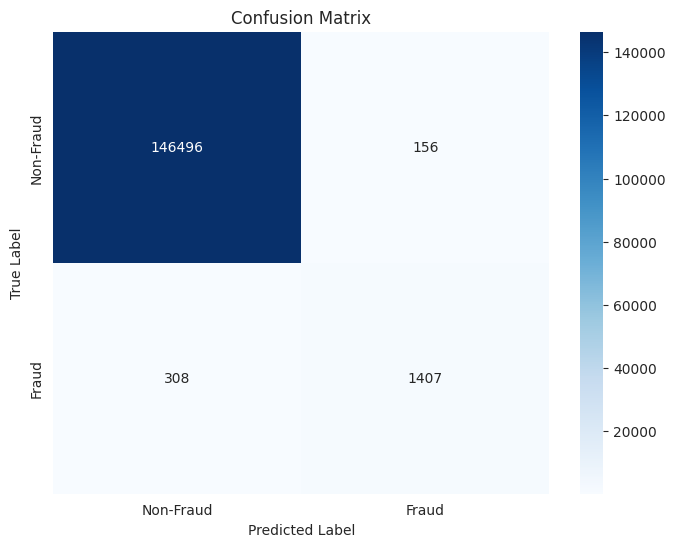

In [ ]:
import faiss
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build FAISS Index
# Extract features and target
features = df_processed_copy.drop(columns=['isFraud'])
target = df_processed_copy['isFraud'].values

# Create embeddings
embedding_matrix = features.values.astype('float32')

# Ensure the array is C-contiguous
embedding_matrix = np.ascontiguousarray(embedding_matrix)

# Now you can safely pass 'embedding_matrix' to FAISS
dimension = embedding_matrix.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance
index.add(embedding_matrix)  # Add embeddings to the index

# Example usage: Retrieve similar transactions
def get_similar_transactions(transaction_vector, k=5):
    # Ensure the transaction vector is C-contiguous as well
    transaction_vector = np.ascontiguousarray(transaction_vector)
    D, I = index.search(np.array([transaction_vector]), k)  # Retrieve k nearest neighbors
    return I  # Return indices of similar transactions

# Example: Get similar transactions for the first transaction in the dataset
similar_transactions = get_similar_transactions(embedding_matrix[0])

# Anomaly detection (this can be refined using statistical methods or additional ML models)
def detect_anomaly(transaction_vector, threshold=0.8):
    similar_idx = get_similar_transactions(transaction_vector, k=10)
    similar_transactions = embedding_matrix[similar_idx]
    mean_distance = np.mean(np.linalg.norm(similar_transactions - transaction_vector, axis=1))
    return mean_distance > threshold

# Step 4: Model Training
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Train a RandomForest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 5: Inference
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate the model

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Classification Report
print(classification_report(y_test, y_pred))

# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {auc_roc}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [ ]:
df_processed.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount
0,0,C1093826151,4,1,28007,M348934600,28007,12,4.55,0,0,1,28.240719
1,0,C352968107,2,1,28007,M348934600,28007,12,39.68,0,0,1,32.661361
2,0,C2054744914,4,0,28007,M1823072687,28007,12,26.89,0,0,1,41.443692
3,0,C1760612790,3,1,28007,M348934600,28007,12,17.25,0,0,1,30.338772
4,0,C757503768,5,1,28007,M348934600,28007,12,35.72,0,0,1,31.696759


# RAG Test

In [40]:
# removing originZipCode and merchantZipCode as both are similar across all records

df_processed_rag = df_processed_rag.drop(columns=['originZipCode', 'merchantZipCode'])


In [68]:
def categorize_amount(amount):
    if amount < 1:
        return 'very less amount'
    elif 1 <= amount < 100:
        return 'low amount'
    elif 100 <= amount < 1000:
        return 'intermediate amount'
    elif 1000 <= amount < 5000:
        return 'large amount'
    else:
        return 'very large amount'

df_processed_rag['bhv_amount'] = df_processed_rag['amount'].apply(categorize_amount)


In [69]:
df_processed_rag['bhv_frequent'] = df_processed_rag['countForCustomerSameTime'].apply(
    lambda x: 'uncommon transaction' if x == 1 else 'recurring transaction'
)

In [70]:
df_processed_rag['bhv_isFraud'] = df_processed_rag['isFraud'].apply(
    lambda x: 'fraudlent transaction' if x == 1 else 'genuine transaction'
)

In [71]:
df_processed_rag['customerAge'] = pd.to_numeric(df_processed_rag['customerAge'], errors='coerce')

def categorize_customerAge(customerAge):
    if pd.isna(customerAge):  # Handle NaN values
        return 'Unknown'
    elif customerAge < 2:
        return 'Teenage'
    elif 2 <= customerAge < 4:
        return 'Young Adults'
    else:
        return 'Adults'

df_processed_rag['bhv_customerAge'] = df_processed_rag['customerAge'].apply(categorize_customerAge)



In [84]:
df_processed_rag['transaction_behavior'] = df_processed_rag.apply(
    lambda row: f"A {row['bhv_frequent']} originated from {row['bhv_customerAge']} customer {row['customerId']} "
                f"from merchant {row['merchantName']} to category {row['merchantCategory']} "
                f"with {row['bhv_amount']} is categorized as {row['bhv_isFraud']}",
    axis=1
)

In [83]:
# Write pre-processed data to .csv files for manual analysis

# Specifying the filename
output_file = 'df_processed_rag.csv'

# Export the DataFrame to CSV
df_processed_rag.to_csv(output_file, index=False)

print(f"DataFrame has been exported to {output_file}")


DataFrame has been exported to df_processed_rag.csv


In [85]:
df_subset = df_processed_rag.head(1000)

In [60]:
pip install transformers faiss-gpu pandas numpy


In [86]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd

# Load pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

# Function to generate embeddings
def generate_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Mean pooling to get the final embedding
    embeddings = torch.mean(outputs.last_hidden_state, dim=1).squeeze().numpy()
    return embeddings

# Apply the function to generate embeddings for each transaction behavior
df_subset['embedding'] = df_subset['transaction_behavior'].apply(generate_embedding)


<ipython-input-86-2fd55f87f2f1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['embedding'] = df_subset['transaction_behavior'].apply(generate_embedding)


In [89]:
# Store generated embeddings in a vector store
import faiss
import numpy as np

# Convert the embeddings to a NumPy array
embeddings = np.vstack(df_subset['embedding'].values)

# Define the dimension of the embeddings
embedding_dim = embeddings.shape[1]

# Create a FAISS index
index = faiss.IndexFlatL2(embedding_dim)

# Add embeddings to the index
index.add(embeddings)

# Optionally, save the FAISS index to disk
faiss.write_index(index, 'transaction_behavior_index.faiss')


In [91]:
# Querying the vector store

# Example query (assuming a new transaction behavior string)
query_text = "A recurring transaction originated from Young Adults with low amount"
query_embedding = generate_embedding(query_text).reshape(1, -1)

# Search the index
D, I = index.search(query_embedding, k=5)  # Retrieve top 5 closest vectors

# Retrieve corresponding records
similar_records = df_processed_rag.iloc[I[0]]
print(similar_records)


     timeStep   customerId  customerAge customerGender merchantName  \
88          0   C583110837            3              M   M480139044   
554         0    C60026962            2              F  M1198415165   
853         0   C583110837            3              M   M480139044   
605         0  C1275518867            5              F   M980657600   
854         0  C1079254393            1              F   M480139044   

         merchantCategory  amount  isFraud  IslargeTransaction  \
88              es_health   44.26        1                   0   
554  es_wellnessandbeauty    4.32        1                   0   
853             es_health  667.09        1                   0   
605      es_sportsandtoys   69.53        1                   0   
854             es_health  520.50        1                   0   

     countForCustomerSameTime  avgTransactionAmount           bhv_amount  \
88                          3            114.287643           low amount   
554                     

In [88]:
df_subset[df_subset['isFraud'] == 1].head()

,timeStep,customerId,customerAge,customerGender,merchantName,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,bhv_amount,bhv_frequent,bhv_customerAge,transaction_behavior,bhv_isFraud,embedding
88,0,C583110837,3,M,M480139044,es_health,44.26,1,0,3,114.287643,low amount,recurring transaction,Young Adults,A recurring transaction originated from Young ...,fraudlent transaction,"[-0.11552497, 0.17454731, -0.05036496, -0.1420..."
89,0,C1332295774,3,M,M480139044,es_health,324.50,1,0,1,134.065849,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.062864356, 0.17927471, -0.065637514, -0.17..."
434,0,C1160421902,3,M,M857378720,es_hotelservices,176.32,1,0,1,45.603140,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.020672405, 0.17260832, -0.07500544, -0.087..."
435,0,C966214713,3,M,M857378720,es_hotelservices,337.41,1,0,1,39.378900,intermediate amount,uncommon transaction,Young Adults,A uncommon transaction originated from Young A...,fraudlent transaction,"[-0.06483217, 0.16667625, -0.06426297, -0.0666..."
553,0,C1450140987,4,F,M1198415165,es_wellnessandbeauty,220.11,1,0,1,74.301611,intermediate amount,uncommon transaction,Adults,A uncommon transaction originated from Adults ...,fraudlent transaction,"[-0.09511135, 0.15435031, -0.008027926, -0.120..."


# RAG

In [ ]:
import pandas as pd

def sample_records(df, total_records=10000, fraud_fraction=0.05, random_state=1):
    """
    Samples a subset from the given DataFrame with a specific total number of records
    and a specified fraction of fraudulent records. This is done to mitigate
    computation overhead when calling OPEN_API

    Parameters:
    - df: pd.DataFrame
        The input DataFrame containing the records.
    - total_records: int, optional (default=10000)
        Total number of records in the output DataFrame.
    - fraud_fraction: float, optional (default=0.05)
        The fraction of records that should be fraudulent.
    - random_state: int, optional (default=1)
        Seed for the random number generator (for reproducibility).

    Returns:
    - pd.DataFrame
        A DataFrame containing the sampled records with the desired proportion
        of fraudulent and non-fraudulent records.
    """
    # Separate records where isFraud = 1
    fraudulent_records = df[df['isFraud'] == 1]

    # Separate records where isFraud = 0
    non_fraudulent_records = df[df['isFraud'] == 0]

    # Calculate the number of samples needed for each group
    fraudulent_sample_size = int(total_records * fraud_fraction)
    non_fraudulent_sample_size = total_records - fraudulent_sample_size

    # Sample from each group
    sampled_fraudulent = fraudulent_records.sample(
        n=fraudulent_sample_size,
        random_state=random_state
    )
    sampled_non_fraudulent = non_fraudulent_records.sample(
        n=non_fraudulent_sample_size,
        random_state=random_state
    )

    # Combine the sampled data
    sampled_df = pd.concat([sampled_fraudulent, sampled_non_fraudulent])

    # Shuffle the combined DataFrame
    sampled_df = sampled_df.sample(
        frac=1,
        random_state=random_state
    ).reset_index(drop=True)

    return sampled_df


In [ ]:
sampled_df = sample_records(df_processed_rag, total_records=10000, fraud_fraction=0.05)

In [ ]:
print(sampled_df.head())
print(sampled_df['isFraud'].value_counts())

   timeStep   customerId customerAge  customerGender originZipCode  \
0       135   C703281362           2               0         28007   
1        69   C686064678           2               0         28007   
2       163  C1702404555           3               1         28007   
3        40   C956794113           3               0         28007   
4        47   C861002792           3               0         28007   

  merchantName merchantZipCode  merchantCategory  amount  isFraud  \
0  M1823072687           28007                12    5.72        0   
1  M1823072687           28007                12    9.25        0   
2  M1823072687           28007                12    3.74        0   
3  M1823072687           28007                12   39.26        0   
4  M1823072687           28007                12   25.15        0   

   IslargeTransaction  countForCustomerSameTime  avgTransactionAmount  
0                   0                         1             30.764675  
1                   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess_data_for_rag(df, feature_columns, target_column='isFraud', test_size=0.25, random_state=42):
    """
    Preprocesses the data by selecting features, splitting into train and test sets, and scaling the features.

    Parameters:
    - df: pd.DataFrame
        The input DataFrame containing the data.
    - feature_columns: list of str
        List of column names to be used as features.
    - target_column: str, optional (default='isFraud')
        The column name to be used as the target variable.
    - test_size: float, optional (default=0.5)
        The proportion of the dataset to include in the test split.
    - random_state: int, optional (default=42)
        Seed for the random number generator (for reproducibility).

    Returns:
    - X_train_scaled: numpy.ndarray
        Scaled training features.
    - X_test_scaled: numpy.ndarray
        Scaled test features.
    - y_train: pd.Series
        Training target values.
    - y_test: pd.Series
        Test target values.
    """
    # Select features and target
    features = df[feature_columns].copy()
    X = features.drop(columns=[target_column])
    y = features[target_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


In [ ]:
column_list = ['timeStep','customerAge','customerGender','merchantCategory','amount','isFraud','IslargeTransaction','countForCustomerSameTime','avgTransactionAmount']
rag_processed_df = preprocess_data_for_rag(sampled_df, column_list)

In [ ]:
import os
import openai
import concurrent.futures
import pandas as pd

# Set API Key
##os.environ["OPENAI_API_KEY"] =
openai.api_key = os.getenv("OPENAI_API_KEY")

def get_embeddings_parallel(texts):
    """
    Retrieve embeddings for a list of texts using parallel processing.

    Parameters:
    - texts: list of str
        The list of texts for which embeddings are to be retrieved.

    Returns:
    - list of list of float
        The embeddings for each text.
    """
    def get_single_embedding(text):
        response = openai.Embedding.create(
            model="text-embedding-ada-002",
            input=text
        )
        return response['data'][0]['embedding']

    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Map the executor to the function and texts
        futures = [executor.submit(get_single_embedding, text) for text in texts]
        return [future.result() for future in concurrent.futures.as_completed(futures)]

def add_embeddings_to_df(df, text_column, embedding_column='embedding'):
    """
    Adds embeddings for a text column to the DataFrame.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the text data.
    - text_column: str
        The name of the column containing the text data.
    - embedding_column: str, optional (default='embedding')
        The name of the column to add with the embeddings.

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column containing embeddings.
    """
    texts = df[text_column].tolist()
    embeddings = get_embeddings_parallel(texts)

    df[embedding_column] = embeddings
    return df


In [ ]:
rag_processed_df = features.loc[X_test.index]
print("Number of rows in rag_processed_df:", len(rag_processed_df))

Number of rows in rag_processed_df: 5000


In [ ]:
import numpy as np

def generate_embeddings_for_features(df, feature_columns, embedding_function, embedding_column='embedding'):
    """
    Combines specified feature columns into a single string, retrieves embeddings for the combined strings,
    and returns a DataFrame with embeddings as a 2D array.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the feature columns.
    - feature_columns: list of str
        List of column names to be combined into a single string.
    - embedding_function: function
        Function that takes a list of texts and returns a list of embeddings.
    - embedding_column: str, optional (default='embedding')
        The name of the column to add with the embeddings.

    Returns:
    - pd.DataFrame
        The original DataFrame with an additional column containing embeddings as a 2D array.
    - np.ndarray
        A 2D numpy array where each row represents the flattened embedding of a combined feature string.
    """
    # Convert specified columns to string type and combine them into a single string
    for col in feature_columns:
        df[col] = df[col].astype(str)

    df['combined_features'] = df[feature_columns].apply(lambda row: ' '.join(row), axis=1)

    # Get embeddings for the combined column
    combined_texts = df['combined_features'].tolist()
    embeddings_list = embedding_function(combined_texts)

    # Flatten each embedding to make it 1D and convert to a 2D array
    embeddings_array = np.array([np.array(embedding).flatten() for embedding in embeddings_list])

    # Add the embeddings to the DataFrame
    df[embedding_column] = list(embeddings_array)

    return df, embeddings_array

In [ ]:
# Example usage
feature_columns = ['customerAge', 'customerGender', 'amount',
                   'IslargeTransaction', 'countForCustomerSameTime',
                   'avgTransactionAmount', 'isFraud']

df_test_with_embeddings, embeddings_array = generate_embeddings_for_features(
    rag_processed_df,
    feature_columns,
    get_embeddings_parallel
)

print("Number of rows in df_test_with_embeddings:", len(df_test_with_embeddings))
print("Shape of embeddings_array:", embeddings_array.shape)

Number of rows in df_test_with_embeddings: 5000
Shape of embeddings_array: (5000, 1536)


In [ ]:
embeddings_array

array([[ 0.00730173,  0.00072604, -0.00116555, ..., -0.00481725,
        -0.00018077, -0.02052305],
       [-0.00218893, -0.00120013,  0.00152228, ...,  0.00423696,
        -0.00250335, -0.01714028],
       [ 0.01303572, -0.00176006, -0.00527848, ..., -0.00956681,
        -0.02189236, -0.00975801],
       ...,
       [-0.0087584 , -0.00387391,  0.00225529, ..., -0.00448026,
        -0.01313087, -0.00931086],
       [ 0.00813869, -0.00677314,  0.00069857, ...,  0.00282669,
        -0.01224217, -0.00183667],
       [ 0.00575101,  0.00339739, -0.00948316, ..., -0.00983337,
         0.00061501, -0.01532688]])

In [ ]:
# Normalize the embeddings using StandardScaler
scaler = StandardScaler()
try:
    normalized_embeddings = scaler.fit_transform(embeddings_array)
except ValueError as e:
    print("Error during normalization:", e)
    print("Shape of embeddings array before normalization:", embeddings_array.shape)

In [ ]:
from scipy.spatial.distance import pdist, squareform

# Calculate cosine dissimilarity matrix (1 - cosine similarity)
cosine_dissimilarity_matrix = squareform(pdist(normalized_embeddings, 'cosine'))

In [ ]:
import matplotlib.pyplot as plt

def test_threshold_multipliers(cosine_dissimilarity_matrix, multipliers=[1.0, 1.5, 2.0, 3.0]):
    flattened_matrix = cosine_dissimilarity_matrix.flatten()
    plt.figure(figsize=(12, 8))

    for multiplier in multipliers:
        mean_dissimilarity = np.mean(flattened_matrix)
        std_dissimilarity = np.std(flattened_matrix)
        threshold = mean_dissimilarity + multiplier * std_dissimilarity

        anomalies = np.sum(flattened_matrix > threshold)
        plt.hist(flattened_matrix[flattened_matrix <= threshold], bins=30, alpha=0.5, label=f'Below Threshold {multiplier}')
        plt.hist(flattened_matrix[flattened_matrix > threshold], bins=30, alpha=0.5, label=f'Above Threshold {multiplier}')
        print(f"Multiplier: {multiplier}, Number of anomalies detected: {anomalies}")

    plt.legend()
    plt.xlabel('Dissimilarity Score')
    plt.ylabel('Frequency')
    plt.title('Histogram of Dissimilarity Scores with Various Thresholds')
    plt.show()

Multiplier: 1.0, Number of anomalies detected: 3386088
Multiplier: 1.5, Number of anomalies detected: 746806
Multiplier: 2.0, Number of anomalies detected: 72426
Multiplier: 3.0, Number of anomalies detected: 18


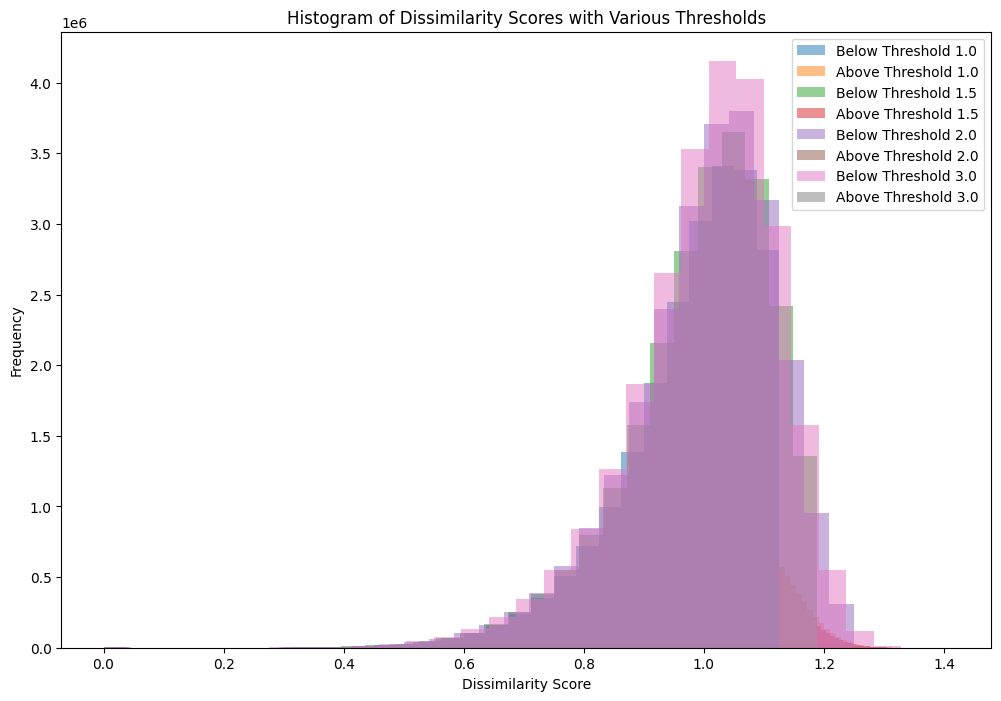

In [ ]:
test_threshold_multipliers(cosine_dissimilarity_matrix)

In [ ]:
def detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier=2.5):
    """
    Detects anomalies in a cosine dissimilarity matrix based on a calculated threshold.

    Parameters:
    - cosine_dissimilarity_matrix: np.ndarray
        A 2D numpy array representing the cosine dissimilarity matrix.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.

    Returns:
    - threshold: float
        The calculated threshold for identifying anomalies.
    - anomaly_indices: tuple of np.ndarray
        Indices of the anomalies in the dissimilarity matrix.
    """
    # Calculate mean and standard deviation of the dissimilarity matrix
    mean_dissimilarity = np.mean(cosine_dissimilarity_matrix)
    std_dissimilarity = np.std(cosine_dissimilarity_matrix)

    # Compute the threshold for anomalies
    threshold = mean_dissimilarity + threshold_multiplier * std_dissimilarity

    # Identify indices of the anomalies
    anomaly_indices = np.where(cosine_dissimilarity_matrix > threshold)

    return threshold, anomaly_indices

In [ ]:
threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix)

print("Threshold for anomalies:", threshold)
print("Anomaly indices:", anomaly_indices)

Threshold for anomalies: 1.3132440125409626
Anomaly indices: (array([   1,    1,    1, ..., 4994, 4997, 4997]), array([ 421, 1996, 4395, ..., 2266,  523, 3000]))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, f1_score
import matplotlib.pyplot as plt

def detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier=2.5):
    flattened_matrix = cosine_dissimilarity_matrix.flatten()
    mean_dissimilarity = np.mean(flattened_matrix)
    std_dissimilarity = np.std(flattened_matrix)
    threshold = mean_dissimilarity + threshold_multiplier * std_dissimilarity
    anomaly_indices = np.argwhere(cosine_dissimilarity_matrix > threshold)
    return threshold, anomaly_indices

def mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier=2.5, anomaly_column='embedding_cosine_isAnomaly'):
    threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier)
    anomaly_pairs = list(zip(anomaly_indices[0], anomaly_indices[1]))
    anomaly_transactions = set()
    for i, j in anomaly_pairs:
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)
    index_mapping = df.index.tolist()
    mapped_anomaly_indices = [index_mapping[i] for i in anomaly_transactions]
    df[anomaly_column] = 0
    df.loc[mapped_anomaly_indices, anomaly_column] = 1
    return df

def evaluate_thresholds(df, cosine_dissimilarity_matrix, thresholds, ground_truth_indices):
    results = []
    for threshold_multiplier in thresholds:
        df_with_anomalies = mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier)
        predicted_anomalies = df_with_anomalies['embedding_cosine_isAnomaly'].values
        ground_truth = np.zeros(len(df))
        ground_truth[ground_truth_indices] = 1
        precision, recall, _ = precision_recall_curve(ground_truth, predicted_anomalies)
        f1 = f1_score(ground_truth, predicted_anomalies)
        results.append({
            'threshold_multiplier': threshold_multiplier,
            'f1_score': f1,
            'precision': precision.mean(),
            'recall': recall.mean()
        })
    return pd.DataFrame(results)

In [ ]:
ground_truth_indices = rag_processed_df.index[rag_processed_df['isFraud'] == '1'].tolist()

# Sort indices in ascending order
ground_truth_indices = sorted(ground_truth_indices)

# Pick the first five elements from the sorted list
ground_truth_indices = ground_truth_indices[:5]
print(f"Ground truth indices: {ground_truth_indices}")

Ground truth indices: [70, 90, 91, 227, 274]


   threshold_multiplier  f1_score  precision    recall
0                   1.0       0.0   0.333667  0.333333
1                   1.5       0.0   0.333667  0.333333
2                   2.0       0.0   0.333667  0.333333
3                   2.5       0.0   0.333667  0.333333
4                   3.0       0.0   0.333667  0.333333


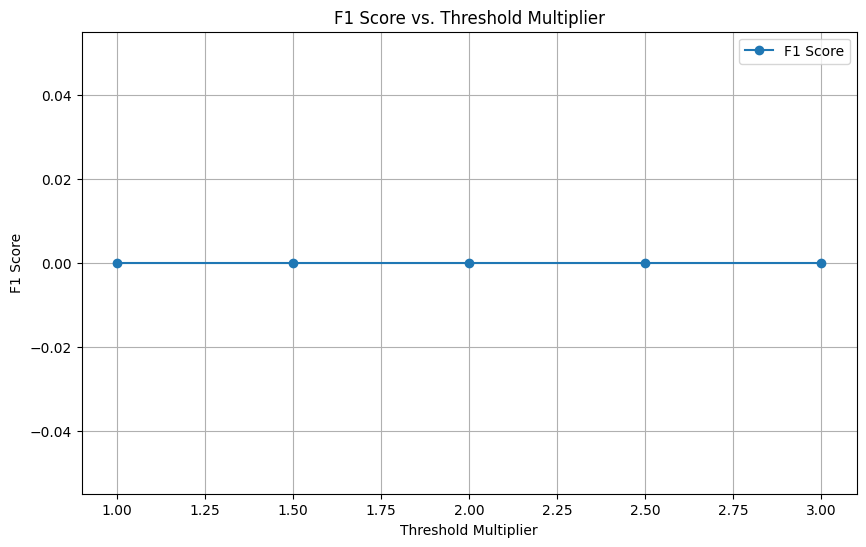

In [ ]:
# Define ground truth indices (for example purposes, assume indices 10 to 14 are anomalies)
ground_truth_indices = ground_truth_indices

# Define threshold multipliers to test
thresholds = [1.0, 1.5, 2.0, 2.5, 3.0]

# Evaluate thresholds
results_df = evaluate_thresholds(rag_processed_df, cosine_dissimilarity_matrix, thresholds, ground_truth_indices)

# Print results
print(results_df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold_multiplier'], results_df['f1_score'], marker='o', label='F1 Score')
plt.xlabel('Threshold Multiplier')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold Multiplier')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def mark_anomalies_in_df(df, cosine_dissimilarity_matrix, threshold_multiplier=2.5, anomaly_column='embedding_cosine_isAnomaly'):
    """
    Identifies and marks anomalies in the DataFrame based on the cosine dissimilarity matrix.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the transactions.
    - cosine_dissimilarity_matrix: np.ndarray
        A square 2D numpy array representing the cosine dissimilarity matrix.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.
    - anomaly_column: str, optional (default='embedding_cosine_isAnomaly')
        The name of the column to add with the anomaly indicator (0 or 1).

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column marking anomalies.
    """
    # Detect anomalies
    threshold, anomaly_indices = detect_anomalies(cosine_dissimilarity_matrix, threshold_multiplier)

    # Since cosine_dissimilarity_matrix is a square matrix, we get pairs of indices
    anomaly_pairs = list(zip(anomaly_indices[0], anomaly_indices[1]))

    # Map these pairs back to the original transactions
    anomaly_transactions = set()
    for i, j in anomaly_pairs:
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)

    # Create a mapping from new indices to original indices
    index_mapping = df.index.tolist()

    # Map the anomaly indices to original indices
    mapped_anomaly_indices = [index_mapping[i] for i in anomaly_transactions]

    # Add an 'embedding_cosine_isAnomaly' column to the DataFrame
    df[anomaly_column] = 0
    df.loc[mapped_anomaly_indices, anomaly_column] = 1

    return df

In [ ]:
df_test_with_anomalies = mark_anomalies_in_df(rag_processed_df, cosine_dissimilarity_matrix)

print("DataFrame with anomalies marked:")
print(df_test_with_anomalies)


DataFrame with anomalies marked:
     timeStep customerAge customerGender  merchantCategory  amount isFraud  \
6252      133           4              0                12   31.46       0   
4684       31           5              0                10  295.39       1   
1731       41           2              1                 0   30.73       0   
4742      128           3              0                12   14.04       0   
4521      137           2              0                12   11.38       0   
...       ...         ...            ...               ...     ...     ...   
5743      136           3              1                12   25.21       0   
6226      173           1              0                 6  139.39       1   
1973      102           2              0                12   14.53       0   
336       163           2              1                 3   67.99       0   
2764      155           2              1                12    0.02       0   

     IslargeTransaction countF

In [ ]:
df_test_with_anomalies[df_test_with_anomalies['embedding_cosine_isAnomaly'] == 1]

,timeStep,customerAge,customerGender,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined_features,embedding,embedding_cosine_isAnomaly
1498,161,5,1,12,26.57,0,0,1,29.383086419753088,5 1 26.57 0 1 29.383086419753088 0,"[0.00234853639267385, -0.006333931349217892, 0...",1
8285,175,1,1,12,14.02,0,0,1,32.93335227272728,1 1 14.02 0 1 32.93335227272728 0,"[0.007576659321784973, -0.0014738020254299045,...",1


In [ ]:
from scipy.spatial.distance import pdist, squareform

def detect_and_mark_anomalies(df, normalized_embeddings, threshold_multiplier=2.5, anomaly_column='embedding_euclidean_isAnomaly'):
    """
    Detects anomalies based on the Euclidean distance matrix and marks them in the DataFrame.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the transactions.
    - normalized_embeddings: np.ndarray
        A 2D numpy array where each row is an embedding vector.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.
    - anomaly_column: str, optional (default='embedding_euclidean_isAnomaly')
        The name of the column to add with the anomaly indicator (0 or 1).

    Returns:
    - pd.DataFrame
        The DataFrame with an additional column marking anomalies.
    """
    # Calculate Euclidean distance matrix
    euclidean_distance_matrix = squareform(pdist(normalized_embeddings, 'euclidean'))

    # Find the threshold for anomalies using Euclidean distance
    mean_euclidean = np.mean(euclidean_distance_matrix)
    std_euclidean = np.std(euclidean_distance_matrix)
    threshold_euclidean = mean_euclidean + threshold_multiplier * std_euclidean

    # Extract anomalies from distance matrix
    def extract_anomalies(distance_matrix, threshold):
        anomaly_indices = np.where(distance_matrix > threshold)
        anomaly_transactions = set()
        for i, j in zip(*anomaly_indices):
            if i != j:
                anomaly_transactions.add(i)
                anomaly_transactions.add(j)
        return anomaly_transactions

    euclidean_anomalies = extract_anomalies(euclidean_distance_matrix, threshold_euclidean)

    # Create a mapping from new indices to original indices
    index_mapping = df.index.tolist()

    # Map the anomaly indices to original indices
    mapped_euclidean_anomalies = [index_mapping[i] for i in euclidean_anomalies]

    # Add an 'embedding_euclidean_isAnomaly' column to the DataFrame
    df[anomaly_column] = 0
    df.loc[mapped_euclidean_anomalies, anomaly_column] = 1

    return df

In [ ]:
df_test_with_anomalies = detect_and_mark_anomalies(df_test_with_anomalies, normalized_embeddings)

In [ ]:
df_test_with_anomalies

,timeStep,customerAge,customerGender,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined_features,embedding,embedding_cosine_isAnomaly,embedding_euclidean_isAnomaly
6252,133,4,0,12,31.46,0,0,1,38.851282051282055,4 0 31.46 0 1 38.851282051282055 0,"[0.007301728241145611, 0.0007260433048941195, ...",0,1
4684,31,5,0,10,295.39,1,0,2,34.96363057324841,5 0 295.39 0 2 34.96363057324841 1,"[-0.0021889253985136747, -0.001200129045173525...",0,0
1731,41,2,1,0,30.73,0,0,1,35.37522727272727,2 1 30.73 0 1 35.37522727272727 0,"[0.013035720214247704, -0.0017600612482056022,...",0,1
4742,128,3,0,12,14.04,0,0,1,29.303507462686568,3 0 14.04 0 1 29.303507462686568 0,"[-0.0034494854044169188, 0.008038683794438839,...",0,0
4521,137,2,0,12,11.38,0,0,1,29.155083798882682,2 0 11.38 0 1 29.155083798882682 0,"[-0.004887760616838932, -0.0027695049066096544...",0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5743,136,3,1,12,25.21,0,0,1,30.01531791907514,3 1 25.21 0 1 30.01531791907514 0,"[0.005353336222469807, -0.0025564071256667376,...",0,1
6226,173,1,0,6,139.39,1,0,2,513.8887,1 0 139.39 0 2 513.8887 1,"[0.010760649107396603, -0.006377437151968479, ...",0,0
1973,102,2,0,12,14.53,0,0,1,33.85966292134831,2 0 14.53 0 1 33.85966292134831 0,"[-0.008758404292166233, -0.0038739098235964775...",0,1
336,163,2,1,3,67.99,0,0,1,35.281098265895956,2 1 67.99 0 1 35.281098265895956 0,"[0.008138689212501049, -0.006773137021809816, ...",0,1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compare_anomaly_detection_approaches(df, X_test, y_test, anomaly_columns, threshold_multiplier=1.5):
    """
    Compares different anomaly detection approaches and generates a summary report.

    Parameters:
    - df: pd.DataFrame
        The DataFrame containing the test data and anomaly detection results.
    - X_test: pd.DataFrame
        The test features.
    - y_test: pd.Series
        The true labels for the test set.
    - anomaly_columns: dict
        Dictionary where keys are approach names and values are the column names in df with anomaly indicators.
    - threshold_multiplier: float, optional (default=1.5)
        Multiplier for the standard deviation to calculate the threshold for anomalies.

    Returns:
    - None
    """
    # Function to calculate performance metrics
    def calculate_metrics(y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        return accuracy, precision, recall, f1

    # Initialize the summary report dictionary
    summary = {}

    # Calculate metrics for each approach
    for approach_name, anomaly_column in anomaly_columns.items():
        # Get predictions for the current approach
        predictions = df.loc[X_test.index, anomaly_column]

        # Calculate metrics
        accuracy, precision, recall, f1 = calculate_metrics(y_test, predictions)

        # Store metrics in the summary report
        summary[approach_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    # Print the summary report
    for approach, metrics in summary.items():
        print(f"{approach}:")
        if isinstance(metrics, dict):
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
        else:
            print(f"  {metrics}")
        print()

In [ ]:
anomaly_columns = {
    "Embedding-Cosine Approach": 'embedding_cosine_isAnomaly',
    "Embedding-Euclidean Approach": 'embedding_euclidean_isAnomaly'
}
compare_anomaly_detection_approaches(df_test_with_anomalies, X_test, y_test, anomaly_columns)

Embedding-Cosine Approach:
  Accuracy: 0.9474
  Precision: 0.0
  Recall: 0.0
  F1 Score: 0.0

Embedding-Euclidean Approach:
  Accuracy: 0.3236
  Precision: 0.05528640638358507
  Recall: 0.7432950191570882
  F1 Score: 0.10291777188328913



## ignore below

In [ ]:
# Display columns with non-numeric data
for column in df_processed_rag.columns:
    if df_processed_rag[column].dtype == 'object':
        print(f"Column '{column}' contains non-numeric data")

Column 'customerId' contains non-numeric data
Column 'customerAge' contains non-numeric data
Column 'originZipCode' contains non-numeric data
Column 'merchantName' contains non-numeric data
Column 'merchantZipCode' contains non-numeric data


In [ ]:
# Prepare data by converting it into a text format
# Ensure that all columns are properly converted to strings
df_processed_rag['timeStep'] = df_processed_rag['timeStep'].astype(str)
df_processed_rag['customerId'] = df_processed_rag['customerId'].astype(str)
df_processed_rag['customerAge'] = df_processed_rag['customerAge'].astype(str)
df_processed_rag['customerGender'] = df_processed_rag['customerGender'].astype(str)
df_processed_rag['originZipCode'] = df_processed_rag['originZipCode'].astype(str)
df_processed_rag['merchantName'] = df_processed_rag['merchantName'].astype(str)
df_processed_rag['merchantZipCode'] = df_processed_rag['merchantZipCode'].astype(str)
df_processed_rag['merchantCategory'] = df_processed_rag['merchantCategory'].astype(str)
df_processed_rag['amount'] = df_processed_rag['amount'].astype(str)
df_processed_rag['IslargeTransaction'] = df_processed_rag['IslargeTransaction'].astype(str)
df_processed_rag['countForCustomerSameTime'] = df_processed_rag['countForCustomerSameTime'].astype(str)
df_processed_rag['avgTransactionAmount'] = df_processed_rag['avgTransactionAmount'].astype(str)
df_processed_rag['isFraud'] = df_processed_rag['isFraud'].astype(str)


df_processed_rag['combined'] = df_processed_rag['timeStep'].astype(str) + " " + \
                           df_processed_rag['customerId'].astype(str) + " " + \
                           df_processed_rag['customerAge'].astype(str) + " " + \
                           df_processed_rag['customerGender'] + " " + \
                           df_processed_rag['originZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantName'] + " " + \
                           df_processed_rag['merchantZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantCategory'] + " " + \
                           df_processed_rag['amount'].astype(str) + " " + \
                           df_processed_rag['IslargeTransaction'].astype(str) + " " + \
                           df_processed_rag['countForCustomerSameTime'].astype(str) + " " + \
                           df_processed_rag['avgTransactionAmount'].astype(str) + " " + \
                           df_processed_rag['isFraud'].astype(str)



In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Convert the 'combined' column to a list of strings
texts = df_processed_rag['combined'].tolist()

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Split the texts into chunks
recs = [text_splitter.split_text(text) for text in texts]

# Flatten the list of lists into a single list of recs
recs = [doc for sublist in recs for doc in sublist]

# Display the first 5 recs
recs[:5]


['0 C1093826151 4 1 28007 M348934600 28007 12 4.55 0 1 28.24071856287425 0',
 '0 C352968107 2 1 28007 M348934600 28007 12 39.68 0 1 32.66136094674557 0',
 '0 C2054744914 4 0 28007 M1823072687 28007 12 26.89 0 1 41.44369230769231 0',
 '0 C1760612790 3 1 28007 M348934600 28007 12 17.25 0 1 30.338771929824564 0',
 '0 C757503768 5 1 28007 M348934600 28007 12 35.72 0 1 31.696758620689653 0']

In [ ]:
pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.1 MB/s eta 0:00:00


In [ ]:
pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [ ]:
pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 12.5 MB/s eta 0:00:0

In [ ]:
combined_texts = df_processed_rag['combined'].tolist()

In [ ]:
embeddings_list = get_embeddings_parallel(combined_texts)

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from faiss import IndexFlatL2

# Feature scaling
scaler = StandardScaler()
df_processed_rag[['amount', 'avgTransactionAmount']] = scaler.fit_transform(df_processed_rag[['amount', 'avgTransactionAmount']])

# Splitting features and target
X = df_processed_rag.drop(columns=['isFraud']).values
y = df_processed_rag['isFraud'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure arrays are C-contiguous
X_train = np.ascontiguousarray(X_train, dtype=np.float32)
X_test = np.ascontiguousarray(X_test, dtype=np.float32)

# Retrieval component
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)
D, I = index.search(X_test, k=5)  # Retrieve top 5 similar transactions

# Generative component (e.g., using BERT for classification)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

ValueError: could not convert string to float: 'C1295444668'

In [ ]:
import openai
import faiss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
import concurrent.futures
import asyncio
import pandas as pd
import httpx
import asyncio


# Prepare data by converting it into a text format
# Ensure that all columns are properly converted to strings
df_processed_rag['timeStep'] = df_processed_rag['timeStep'].astype(str)
df_processed_rag['customerId'] = df_processed_rag['customerId'].astype(str)
df_processed_rag['customerAge'] = df_processed_rag['customerAge'].astype(str)
df_processed_rag['customerGender'] = df_processed_rag['customerGender'].astype(str)
df_processed_rag['originZipCode'] = df_processed_rag['originZipCode'].astype(str)
df_processed_rag['merchantName'] = df_processed_rag['merchantName'].astype(str)
df_processed_rag['merchantZipCode'] = df_processed_rag['merchantZipCode'].astype(str)
df_processed_rag['merchantCategory'] = df_processed_rag['merchantCategory'].astype(str)
df_processed_rag['amount'] = df_processed_rag['amount'].astype(str)
df_processed_rag['IslargeTransaction'] = df_processed_rag['IslargeTransaction'].astype(str)
df_processed_rag['countForCustomerSameTime'] = df_processed_rag['countForCustomerSameTime'].astype(str)
df_processed_rag['avgTransactionAmount'] = df_processed_rag['avgTransactionAmount'].astype(str)

df_processed_rag['combined'] = df_processed_rag['timeStep'].astype(str) + " " + \
                           df_processed_rag['customerId'].astype(str) + " " + \
                           df_processed_rag['customerAge'].astype(str) + " " + \
                           df_processed_rag['customerGender'] + " " + \
                           df_processed_rag['originZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantName'] + " " + \
                           df_processed_rag['merchantZipCode'].astype(str) + " " + \
                           df_processed_rag['merchantCategory'] + " " + \
                           df_processed_rag['amount'].astype(str) + " " + \
                           df_processed_rag['IslargeTransaction'].astype(str) + " " + \
                           df_processed_rag['countForCustomerSameTime'].astype(str) + " " + \
                           df_processed_rag['avgTransactionAmount'].astype(str)


In [ ]:
# Load or assume df_processed_rag is your DataFrame
# df_processed_rag = pd.read_csv('your_file.csv')  # Example

# Separate records where isFraud = 1
fraudulent_records = df_processed_rag[df_processed_rag['isFraud'] == 1]

# Separate records where isFraud = 0
non_fraudulent_records = df_processed_rag[df_processed_rag['isFraud'] == 0]

# Calculate the number of samples needed for each group
total_records = 100
fraudulent_sample_size = int(total_records * 0.05)  # 1% of 1000
non_fraudulent_sample_size = total_records - fraudulent_sample_size  # Remaining samples

# Sample from each group
sampled_fraudulent = fraudulent_records.sample(n=fraudulent_sample_size, random_state=1)
sampled_non_fraudulent = non_fraudulent_records.sample(n=non_fraudulent_sample_size, random_state=1)

# Combine the sampled data
sampled_df = pd.concat([sampled_fraudulent, sampled_non_fraudulent])

# Shuffle the combined DataFrame
sampled_df = sampled_df.sample(frac=1, random_state=1).reset_index(drop=True)

# Now you have a DataFrame with 1000 records and the same proportion of isFraud
print(sampled_df.head())
print(sampled_df['isFraud'].value_counts())


  timeStep   customerId customerAge customerGender originZipCode merchantName  \
0        3  C2145933360           5              0         28007   M348934600   
1       55  C1628447668           3              1         28007   M348934600   
2       94  C1249352100           5              1         28007   M348934600   
3      157  C1914582232           2              1         28007   M348934600   
4      138  C1962407385           2              1         28007  M1823072687   

  merchantZipCode merchantCategory amount  isFraud IslargeTransaction  \
0           28007               12  19.23        0                  0   
1           28007               12  57.93        0                  0   
2           28007               12  29.86        0                  0   
3           28007               12  28.02        0                  0   
4           28007               12  13.55        0                  0   

  countForCustomerSameTime avgTransactionAmount  \
0                      

In [ ]:
sampled_df.head()

,timeStep,customerId,customerAge,customerGender,originZipCode,merchantName,merchantZipCode,merchantCategory,amount,isFraud,IslargeTransaction,countForCustomerSameTime,avgTransactionAmount,combined
0,55,C1628447668,3,1,28007,M348934600,28007,12,57.93,0,0,1,30.246047904191617,55 C1628447668 3 1 28007 M348934600 28007 12 5...
1,128,C1158738757,3,1,28007,M1823072687,28007,12,33.74,0,0,1,31.67587570621469,128 C1158738757 3 1 28007 M1823072687 28007 12...
2,56,C1133298590,3,1,28007,M348934600,28007,12,12.4,0,0,1,33.959718309859156,56 C1133298590 3 1 28007 M348934600 28007 12 1...
3,145,C964123988,2,0,28007,M151143676,28007,0,17.15,0,0,1,43.8293220338983,145 C964123988 2 0 28007 M151143676 28007 0 17...
4,62,C231044523,1,1,28007,M1823072687,28007,12,24.05,0,0,1,26.324795321637428,62 C231044523 1 1 28007 M1823072687 28007 12 2...


In [ ]:
# Flatten and convert to a numpy array
embedding_matrix = np.array([np.array(embedding).flatten() for embedding in embeddings_list])

In [ ]:
# Normalize the embeddings
scaler = StandardScaler()
embedding_matrix = np.ascontiguousarray(embedding_matrix)  # Ensure C-contiguous array
normalized_embeddings = scaler.fit_transform(embedding_matrix)

In [ ]:
# Ensure embeddings are float32 and C-contiguous
normalized_embeddings = np.array(normalized_embeddings, dtype='float32')
normalized_embeddings = np.ascontiguousarray(normalized_embeddings)

# Create FAISS index
dimension = normalized_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance

# Add embeddings to the index
index.add(normalized_embeddings)

In [ ]:
# Calculate Cosine and Euclidean dissimilarity matrices
cosine_dissimilarity_matrix = squareform(pdist(normalized_embeddings, 'cosine'))
euclidean_distance_matrix = squareform(pdist(normalized_embeddings, 'euclidean'))

In [ ]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import os
import concurrent.futures

def extract_anomalies(distance_matrix, threshold):
    """
    Extract anomalies from a distance matrix based on a given threshold.

    Parameters:
    - distance_matrix: A 2D numpy array of distances between items.
    - threshold: The distance threshold above which an item is considered an anomaly.

    Returns:
    - A set of indices representing the anomalous items.
    """
    # Find indices where distance exceeds the threshold
    anomaly_indices = np.where(distance_matrix > threshold)

    # Use a set to store unique indices of anomalies
    anomaly_transactions = set()
    for i, j in zip(*anomaly_indices):
        if i != j:
            anomaly_transactions.add(i)
            anomaly_transactions.add(j)

    return anomaly_transactions

# Anomaly detection using cosine dissimilarity
mean_cosine = np.mean(cosine_dissimilarity_matrix)
std_cosine = np.std(cosine_dissimilarity_matrix)
threshold_cosine = mean_cosine + 1.5 * std_cosine

cosine_anomalies = extract_anomalies(cosine_dissimilarity_matrix, threshold_cosine)
mapped_cosine_anomalies = [sampled_df.index[i] for i in cosine_anomalies]
sampled_df['cosine_isAnomaly'] = 0
sampled_df.loc[mapped_cosine_anomalies, 'cosine_isAnomaly'] = 1

In [ ]:
# Anomaly detection using Euclidean distance
mean_euclidean = np.mean(euclidean_distance_matrix)
std_euclidean = np.std(euclidean_distance_matrix)
threshold_euclidean = mean_euclidean + 1.5 * std_euclidean

euclidean_anomalies = extract_anomalies(euclidean_distance_matrix, threshold_euclidean)
mapped_euclidean_anomalies = [sampled_df.index[i] for i in euclidean_anomalies]
sampled_df['euclidean_isAnomaly'] = 0
sampled_df.loc[mapped_euclidean_anomalies, 'euclidean_isAnomaly'] = 1

In [ ]:
pip install openai==0.28

In [ ]:
# RAG: Use generated context
def generate_context_for_transaction(transaction_text):
    response = openai.Completion.create(
        model="text-davinci-003",
        prompt=f"Given the following transaction data: {transaction_text}, describe any potential anomalies or unusual patterns.",
        max_tokens=100
    )
    return response.choices[0].text.strip()

# Generate context and embeddings for context
sampled_df['context'] = sampled_df['combined'].apply(generate_context_for_transaction)
context_texts = sampled_df['context'].tolist()
context_embeddings = get_embeddings_parallel(context_texts)

# Combine context embeddings with original embeddings
combined_embeddings = np.hstack([normalized_embeddings, np.array(context_embeddings)])

# Use FAISS or other models to detect anomalies with combined embeddings
combined_dissimilarity_matrix = squareform(pdist(combined_embeddings, 'cosine'))
combined_mean = np.mean(combined_dissimilarity_matrix)
combined_std = np.std(combined_dissimilarity_matrix)
combined_threshold = combined_mean + 1.5 * combined_std

combined_anomalies = extract_anomalies(combined_dissimilarity_matrix, combined_threshold)
mapped_combined_anomalies = [sampled_df.index[i] for i in combined_anomalies]
sampled_df['rag_isAnomaly'] = 0
sampled_df.loc[mapped_combined_anomalies, 'rag_isAnomaly'] = 1

APIRemovedInV1: 

You tried to access openai.Completion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742
